## <span style="color:DarkGreen"> *Meteogram for ASOS, CFI Climate Sentinel, HREF and WINTRE-MIX observations* </span>
***
- Add multi p-types for HRRR\
- Sentinal "whitespace"


### Inputs

In [1]:
# Timeframe for Meteogram
time1 = '2022-02-17 21:00' #'2022-02-22 20:00'
time2 = '2022-02-18 13:00' #'2022-02-23 08:00'
itime = '2022-02-17 12:00' #'2022-02-22 00:00'
IOP = 4

# Station / Manual Observation Site Selection
#obs = 'gu5' # CHANGE ######################
obs_name = 'Gault' # What you want the obs to be called in the title (Gault,Trois-Rivières)
asos_station = 'CYHU' # See Dataframe. (CYHU close to GAULT, CYRQ close to TRIOS)
sent_station = 'GAUL' # ARBO, UQAM, GAUL, TROI

# Lat / Lon for HREF simulations
href_lat =  45.535021 #Gault = 45.535021, Trios = 46.349835
href_lon = 360 - 73.149006  #Gault = 73.149006 Trios = 72.581354

### Imports

In [2]:
%matplotlib inline

# core
import os
import sys
import glob
import math
import cfgrib
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib as mpl

# netCDF4
import netCDF4 as nc
from netCDF4 import Dataset

# datetime
from datetime import datetime,timedelta

#cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat

# Warnings
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

# matplotlib
import matplotlib.colors as mcolors
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import colors
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.dates import DateFormatter, AutoDateLocator,HourLocator,DayLocator,MonthLocator

# metpy
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import StationPlot
from metpy.calc import wind_speed, wind_direction, relative_humidity_from_dewpoint, wind_components
from metpy.calc import wind_speed, wind_direction, relative_humidity_from_dewpoint, wind_components

### HREF Simulations

In [3]:
# Changing input times to datetime objects
time2_dt = datetime.strptime(time2, '%Y-%m-%d %H:%M')
time1_dt = datetime.strptime(time1, '%Y-%m-%d %H:%M')
itime_dt = datetime.strptime(itime, '%Y-%m-%d %H:%M')
href_time = pd.date_range(start=time1_dt,end=time2_dt,freq='1H')

# Filepathing for HREF Files
href_fpath = '/network/rit/lab/minderlab_rit/je845911/data/href' # HREF base filepath
init_d_str = itime[0:4]+itime[5:7]+itime[8:10] # Initalization (year -> day)
init_h_str = itime[0:4]+itime[5:7]+itime[8:10]+itime[11:13] # Initalization (year -> hour)
fhrs_st,fhrs_ed = time1_dt - itime_dt, time2_dt - itime_dt # Finding begining and end fhrs.
fhrs_s, fhrs_e= int((fhrs_st.total_seconds() / 3600)), int((fhrs_ed.total_seconds() / 3600)) # In seconds
fhrs = np.arange(fhrs_s,fhrs_e+1,1) # List of forecasthours
fhrs

arw, fv3, nssl, ncep, nam = [],[],[],[],[]
for fhr in fhrs:
    arw.append(f'{href_fpath}/{itime[0:4]}/{init_d_str}/hiresw_conusarw_' + f'{init_h_str}f0'+str(fhr).zfill(2)+'.grib2')
    fv3.append(f'{href_fpath}/{itime[0:4]}/{init_d_str}/hiresw_conusfv3_' + f'{init_h_str}f0'+str(fhr).zfill(2)+'.grib2')
    nssl.append(f'{href_fpath}/{itime[0:4]}/{init_d_str}/hiresw_conusnssl_' + f'{init_h_str}f0'+str(fhr).zfill(2)+'.grib2')
    ncep.append(f'{href_fpath}/{itime[0:4]}/{init_d_str}/hrrr_ncep_' + f'{init_h_str}f0'+str(fhr).zfill(2)+'.grib2')
    nam.append(f'{href_fpath}/{itime[0:4]}/{init_d_str}/nam_conusnest_' + f'{init_h_str}f0'+str(fhr).zfill(2)+'.grib2')  
    
#Get nearest gridpoint to station lat/lon
with xr.open_mfdataset(arw[0],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260029}) as arw_t:
    arw_test = arw_t['crain']
    arw_t.close()

def get_nearest_gridpoint(xlat, xlong, slat, slon, verbose = False):
    '''Get nearest gridpoint to 2D xarray DataArrays or numpy arrays of model gridpoint latitude and longitude (xlat, xlon),
    given an input lat/lon point (slat, slon)
    Adapted from example code by Brian Blaylock'''
    abslat, abslon = np.fabs(xlat-slat),np.fabs(xlong-slon)
    c = np.maximum(abslon, abslat)
    xyloc = np.where(c == np.min(c))
    xs, ys = xyloc[1][0], xyloc[0][0]
    if verbose: print (f'Found the nearest gridpoint to ({slat} N,{slon} E). Gridpoint: {xs,ys}')
    return (xs, ys)

gridpoints = get_nearest_gridpoint(arw_t['latitude'],arw_t['longitude'],href_lat,href_lon, verbose = True)# CHAZY
station_x, station_y  = gridpoints[0],gridpoints[1]

href_mem = [arw,fv3,nssl,ncep,nam]
arw_RA, fv3_RA, nssl_RA, ncep_RA, nam_RA = [],[],[],[],[]
arw_FR, fv3_FR, nssl_FR, ncep_FR, nam_FR = [],[],[],[],[]
arw_IP, fv3_IP, nssl_IP, ncep_IP, nam_IP = [],[],[],[],[]
arw_SN, fv3_SN, nssl_SN, ncep_SN, nam_SN = [],[],[],[],[]
arw_TP, fv3_TP, nssl_TP, ncep_TP, nam_TP = [],[],[],[],[]


for j in href_mem:
    if j == arw:
        print('Gathering P-type and temperature simulations from the ARW...')
    elif j == fv3:
        print('Gathering P-type and temperature simulations from the FV3...')
    elif j == nssl:
        print('Gathering P-type and temperature simulations from the NSSL...')
    elif j == ncep:
        print('Gathering P-type and temperature simulations from the HRRR...')
    elif j == nam:
        print('Gathering P-type and temperature simulations from the NAM...')
        
    for i in fhrs:
        
        D = i - fhrs_s # Creating variable D to cycle through HREF files 
        
        arw_ra, fv3_ra, nssl_ra, ncep_ra, nam_ra = [],[],[],[],[]
        with xr.open_mfdataset(j[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260029}) as ra:
            
            if j == arw:
                arw_ra = ra['crain'].sel(y = station_y , x = station_x).values
                arw_RA = np.append(arw_RA,arw_ra)
            
            elif j == fv3:
                fv3_ra = ra['crain'].sel(y = station_y , x = station_x).values
                fv3_RA = np.append(fv3_RA,fv3_ra)
                
            elif j == nssl:
                nssl_ra = ra['crain'].sel(y = station_y , x = station_x).values
                nssl_RA = np.append(nssl_RA,nssl_ra)
                
            elif j == ncep:
                ncep_ra = ra['crain'].sel(y = station_y , x = station_x).values
                ncep_RA = np.append(ncep_RA,ncep_ra)
                
            elif j == nam:
                nam_ra = ra['crain'].sel(y = station_y , x = station_x).values
                nam_RA = np.append(nam_RA,nam_ra)
        
        arw_fr, fv3_fr, nssl_fr, ncep_fr, nam_fr = [],[],[],[],[]
        with xr.open_mfdataset(j[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260030}) as fr:            

            if j == arw:
                arw_fr = fr['cfrzr'].sel(y = station_y , x = station_x).values
                arw_FR = np.append(arw_FR,arw_fr)
            
            elif j == fv3:
                fv3_fr = fr['cfrzr'].sel(y = station_y , x = station_x).values
                fv3_FR = np.append(fv3_FR,fv3_fr)
                
            elif j == nssl:
                nssl_fr = fr['cfrzr'].sel(y = station_y , x = station_x).values
                nssl_FR = np.append(nssl_FR,nssl_fr)
                
            elif j == ncep:
                ncep_fr = fr['cfrzr'].sel(y = station_y , x = station_x).values
                ncep_FR = np.append(ncep_FR,ncep_fr)
                
            elif j == nam:
                nam_fr = fr['cfrzr'].sel(y = station_y , x = station_x).values
                nam_FR = np.append(nam_FR,nam_fr)
        
        arw_ip, fv3_ip, nssl_ip, ncep_ip, nam_ip = [],[],[],[],[]
        with xr.open_mfdataset(j[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260031}) as ip:            

            if j == arw:
                arw_ip = ip['cicep'].sel(y = station_y , x = station_x).values
                arw_IP = np.append(arw_IP,arw_ip)
            
            elif j == fv3:
                fv3_ip = ip['cicep'].sel(y = station_y , x = station_x).values
                fv3_IP = np.append(fv3_IP,fv3_ip)
                
            elif j == nssl:
                nssl_ip = ip['cicep'].sel(y = station_y , x = station_x).values
                nssl_IP = np.append(nssl_IP,nssl_ip)
                
            elif j == ncep:
                ncep_ip = ip['cicep'].sel(y = station_y , x = station_x).values
                ncep_IP = np.append(ncep_IP,ncep_ip)
                
            elif j == nam:
                nam_ip = ip['cicep'].sel(y = station_y , x = station_x).values
                nam_IP = np.append(nam_IP,nam_ip)
        
        arw_ra, fv3_sn, nssl_sn, ncep_sn, nam_sn = [],[],[],[],[]
        with xr.open_mfdataset(j[D],engine = 'cfgrib',filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260032}) as sn:

            if j == arw:
                arw_sn = sn['csnow'].sel(y = station_y , x = station_x).values
                arw_SN = np.append(arw_SN,arw_sn)
            
            elif j == fv3:
                fv3_sn = sn['csnow'].sel(y = station_y , x = station_x).values
                fv3_SN = np.append(fv3_SN,fv3_sn)
                
            elif j == nssl:
                nssl_sn = sn['csnow'].sel(y = station_y , x = station_x).values
                nssl_SN = np.append(nssl_SN,nssl_sn)
                
            elif j == ncep:
                ncep_sn = sn['csnow'].sel(y = station_y , x = station_x).values
                ncep_SN = np.append(ncep_SN,ncep_sn)
                
            elif j == nam:
                nam_sn = sn['csnow'].sel(y = station_y , x = station_x).values
                nam_SN = np.append(nam_SN,nam_sn)
        
        arw_tp, fv3_tp, nssl_tp, ncep_tp, nam_tp = [],[],[],[],[]
        with xr.open_dataset(j[D],engine = 'cfgrib',filter_by_keys={'typeOfLevel': 'heightAboveGround','paramId':167}) as tp:

            if j == arw:
                arw_tp = tp['t2m'].sel(y = station_y , x = station_x).values - 273.15
                arw_TP = np.append(arw_TP,arw_tp)
            
            elif j == fv3:
                fv3_tp = tp['t2m'].sel(y = station_y , x = station_x).values - 273.15
                fv3_TP = np.append(fv3_TP,fv3_tp)
                
            elif j == nssl:
                nssl_tp = tp['t2m'].sel(y = station_y , x = station_x).values - 273.15
                nssl_TP = np.append(nssl_TP,nssl_tp)
                
            elif j == ncep:
                ncep_tp = tp['t2m'].sel(y = station_y , x = station_x).values - 273.15 
                ncep_TP = np.append(ncep_TP,ncep_tp)
                
            elif j == nam:
                nam_tp = tp['t2m'].sel(y = station_y , x = station_x).values - 273.15
                nam_TP = np.append(nam_TP,nam_tp) 

arw_flat = np.where(arw_RA > -100, 1.8, 0) 
arw_ptype = np.where(arw_RA == 1,9.99, 0)
arw_ptype = np.where(arw_FR == 1,3.99, arw_ptype)
arw_ptype = np.where(arw_IP == 1,1.99, arw_ptype)
arw_ptype = np.where(arw_SN == 1,0.99, arw_ptype)

fv3_flat = np.where(fv3_RA > -100, 1.7, 0)
fv3_ptype = np.where(fv3_RA == 1,9.99, 0)
fv3_ptype = np.where(fv3_FR == 1,3.99, fv3_ptype)
fv3_ptype = np.where(fv3_IP == 1,1.99, fv3_ptype)
fv3_ptype = np.where(fv3_SN == 1,0.99, fv3_ptype)

nssl_flat = np.where(nssl_RA > -100, 1.6, 0)
nssl_ptype = np.where(nssl_RA == 1,9.99, 0)
nssl_ptype = np.where(nssl_FR == 1,3.99, nssl_ptype)
nssl_ptype = np.where(nssl_IP == 1,1.99, nssl_ptype)
nssl_ptype = np.where(nssl_SN == 1,0.99, nssl_ptype)

ncep_flat = np.where(ncep_RA > -100, 1.5, 0)
ncep_ptype = np.where(ncep_RA == 1,9.99, 0)
ncep_ptype = np.where(ncep_FR == 1,3.99, ncep_ptype)
ncep_ptype = np.where(ncep_IP == 1,1.99, ncep_ptype)
ncep_ptype = np.where(ncep_SN == 1,0.99, ncep_ptype)

nam_flat = np.where(nam_RA > -100, 1.4, 0)
nam_ptype = np.where(nam_RA == 1,9.99, 0)
nam_ptype = np.where(nam_FR == 1,3.99, nam_ptype)
nam_ptype = np.where(nam_IP == 1,1.99, nam_ptype)
nam_ptype = np.where(nam_SN == 1,0.99, nam_ptype)

Found the nearest gridpoint to (45.535021 N,286.850994 E). Gridpoint: (1529, 874)
Gathering P-type and temperature simulations from the ARW...
Gathering P-type and temperature simulations from the FV3...
Gathering P-type and temperature simulations from the NSSL...
Gathering P-type and temperature simulations from the HRRR...
Gathering P-type and temperature simulations from the NAM...


## Manual Observations

In [4]:
# IOP4
pl4 = '/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP4.DOW-US-Plattsburgh.csv'
cc4 = '/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP4.COW-CAN.csv'
dc4 = '/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP4.DOW-CAN-S.csv'
gu4 = '/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP4.Gault.csv'
sl4 = '/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP4.Sorel.csv'

# IOP5
cc5 = '/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP5.COW-CAN.csv'
dc5 = '/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP5.DOW-CAN-N.csv'
du5 = '/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP5.DOW-US-N.csv'
gu5 = '/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP5.Gault.csv'
sl5 = '/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP5.Sorel.csv'
tr5 = '/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP5.TR.csv'

obs = '/network/rit/home/je845911/minlab/field_data/WINTRE_MIX_data/manual_obs/surface.manobs.IOP4.Gault.csv'
sobs_df = pd.read_csv(obs)
sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 'FZRA'),3.99,sobs_df['Primary p-type'])
sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 'FZDZ'),3.99,sobs_df['Primary p-type'])
sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 'FRDZ'),3.99,sobs_df['Primary p-type'])
sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 'DZ'),9.99,sobs_df['Primary p-type'])
sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 'RA'),9.99,sobs_df['Primary p-type'])
sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 'PL'),1.99,sobs_df['Primary p-type'])
sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 'SN'),0.99,sobs_df['Primary p-type'])

sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 'Unknown'),13.99,sobs_df['Primary p-type'])
sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 'Unknown or Uncertain'),13.99,sobs_df['Primary p-type'])
sobs_df['Primary p-type'] = np.where((sobs_df['Primary p-type'] == 'None'),-0.1,sobs_df['Primary p-type'])
sobs_df['Secondary p-type'] = np.where((sobs_df['Secondary p-type'] == 'FZRA'),3.99,sobs_df['Secondary p-type'])
sobs_df['Secondary p-type'] = np.where((sobs_df['Secondary p-type'] == 'FZDZ'),3.99,sobs_df['Secondary p-type'])
sobs_df['Secondary p-type'] = np.where((sobs_df['Secondary p-type'] == 'FRDZ'),3.99,sobs_df['Secondary p-type'])
sobs_df['Secondary p-type'] = np.where((sobs_df['Secondary p-type'] == 'DZ'),9.99,sobs_df['Secondary p-type'])
sobs_df['Secondary p-type'] = np.where((sobs_df['Secondary p-type'] == 'RA'),9.99,sobs_df['Secondary p-type'])
sobs_df['Secondary p-type'] = np.where((sobs_df['Secondary p-type'] == 'PL'),1.99,sobs_df['Secondary p-type'])
sobs_df['Secondary p-type'] = np.where((sobs_df['Secondary p-type'] == 'Unknown'),13.99,sobs_df['Secondary p-type'])
sobs_df['Secondary p-type'] = np.where((sobs_df['Secondary p-type'] == 'Unknown or Uncertain'),13.99,sobs_df['Secondary p-type'])
sobs_df['Secondary p-type'] = np.where((sobs_df['Secondary p-type'] == 'None'),-0.1,sobs_df['Secondary p-type'])
sobs_df['Secondary p-type'] = np.where((sobs_df['Secondary p-type'] == 'SN'),0.99,sobs_df['Secondary p-type'])

#precip_types_map = {'NULL': -0.1,'Snow and/or Graupel': 0.99,'Ice Pellets/Sleet': 1.99,'Mixed Ice Pellets and Snow': 2.99,'Freezing Rain': 3.99,'Freezing Drizzle': 3.99,'Mixed Freezing Rain and Ice Pellets': 6.99,'Rain': 9.99, 'Drizzle': 9.99,'Mixed Rain and Snow': 10.99,'Mixed Rain and Ice Pellets': 11.99,'Unknown Precip': 13.99}

obs_time = sobs_df['Date & time (UTC)']
obs_time = pd.to_datetime(obs_time,format = "%m/%d/%Y %H:%M:%S",utc=True)
sobs_df['Primary p-type']= sobs_df['Primary p-type'].loc[(obs_time> time1) & (obs_time <= time2)]

z_type = np.where(sobs_df['Primary p-type'] > 0, 1.1, 0)
#ip_zr = np.array(cicep + cfzra)
#ip_zr = np.where(ip_zr == 1, 0, ip_zr)
#ip_zr = np.where(ip_zr == 2, 1, ip_zr)

## Sentinel

In [5]:
# Canadian Sentinal Network Data (02/2022 -> 04/2022)
sentinal = '/network/rit/home/je845911/minlab/je845911/data/sentinal/sentinels_metdata.nc'
sent_base = '/network/rit/home/je845911/minlab/je845911/data/sentinal/p-type/sentinels_metdata.nc' # Temperature & Accumulated Precipitation
sent_ice = '/network/rit/home/je845911/minlab/je845911/data/sentinal/p-type/CFI_Sentinels_icing_detector_data_WINTRE-MIX.nc' # Ice Accumulation
sent_snow = '/network/rit/home/je845911/minlab/je845911/data/sentinal/p-type/CFI_Sentinels_Snowdepth.nc' # Snowdepth
sent_precip = '/network/rit/home/je845911/minlab/je845911/data/sentinal/p-type/sentinels_hotplates.nc'

sent_base = xr.open_dataset(sentinal)
sent_base = sent_base.drop(['max_wind_direction','height_above_mean_sea_level','relative_humidity','station_pressure','wind_speed','wind_direction','wind_direction_stddev','max_wind_speed','max_wind_direction'])
sent_base = sent_base.to_dataframe()
sent_base = sent_base.reset_index(level=1)
sent_base = sent_base.rename(columns={"latitude":"lat","longitude":"lon"})

sent_ice = xr.open_dataset(sent_ice, drop_variables = 'station')
sent_ice = sent_ice.drop(['heater_status','ice','height_above_mean_sea_level'])
new_time, empty_time = [], []
sentinal_time, mock_time = datetime(2021,11,1,0,0), range(0,217440,1)
for i in mock_time:
    adj_time = sentinal_time + timedelta(minutes=i)
    new_time.append(adj_time)
time = np.array(new_time)
sent_ice = sent_ice.assign_coords({"time":time})
sent_ice = sent_ice.to_dataframe()
sent_ice = sent_ice.reset_index(level=1)
sent_ice['station'] = sent_ice['station'].replace([0], 'GAUL')
sent_ice['station'] = sent_ice['station'].replace([1], 'ARBO')
sent_ice['station'] = sent_ice['station'].replace([2], 'UQAM')
sent_ice['station'] = sent_ice['station'].replace([3], 'TROI')
sent_ice.loc[sent_ice['lon'] < 0, 'lon'] = sent_ice['lon'] - sent_ice['lon'] - sent_ice['lon'] # Change Lon values from - to +

sent_snow = xr.open_dataset(sent_snow)
sent_snow = sent_snow.drop(['height_above_mean_sea_level','swe_cs725'])
new_time, empty_time = [], []
sentinal_time, mock_time = datetime(2021,11,1,0,0), range(0,216001,1)
for i in mock_time:
    adj_time = sentinal_time + timedelta(minutes=i)
    new_time.append(adj_time)
time = np.array(new_time)
sent_snow = sent_snow.assign_coords({"time":time})
sent_snow = sent_snow.to_dataframe()
sent_snow = sent_snow.reset_index(level=1)
sent_snow = sent_snow.rename(columns={"latitude":"lat","longitude":"lon"})
sent_snow.loc[sent_snow['lon'] < 0, 'lon'] = sent_snow['lon'] - sent_snow['lon'] - sent_snow['lon'] # Change Lon values from - to +

sent_ap = xr.open_dataset(sent_precip)
sent_ap = sent_ap.to_dataframe()
sent_ap = sent_ap.rename(columns={"latitude":"lat","longitude":"lon"})
sent_ap = sent_ap.drop(columns=['height_above_mean_sea_level','status_k63'])


sent_total = pd.merge(sent_ice, sent_base, on=["time","lat","lon"])
sent_total = pd.merge(sent_total, sent_snow, on=['time',"station"])
sent_total = pd.merge(sent_total, sent_ap, on=['time',"station"])
sent_total = sent_total.drop(columns=['lat_y','lon_y','lat','lon'])
sent_total = sent_total.rename(columns={"lat_x":"lat","lon_x":"lon"})
sent_total = sent_total.set_index(['time','station'])
sent_total.index.names
sent_total = sent_total.loc[(time1):(time2)]

sent_total['snow_depth_avg_sdms40'] = sent_total['snow_depth_avg_sdms40'].diff(periods = 4)
sent_total['snow_depth_sr50a'] = sent_total['snow_depth_sr50a'].diff(periods = 4)

sent_total['ice_status'] = sent_total['ice_status'].replace([b'Y'], 1)
sent_total['ice_status'] = sent_total['ice_status'].replace([b'N'], 0)
sent_total['ice_status'] = sent_total['ice_status'].replace([b'E'], 0)
sent_total['ice_status'] = sent_total['ice_status'].replace([b'M'], 0)
sent_total['ice_status'] = sent_total['ice_status'].replace([b'Q'], 0)



xr = sent_total.to_xarray()
xr['ice_status'].astype(int)
xr_ice= xr.resample(time='5min').max(dim='time')
xr = xr.resample(time='5min').mean(dim='time')

for i in xr['station'].values:

    # P_TYPE NO PRECIP. CHECK (0.0004)
    a = np.where(xr['precipitation_rate_k63'].sel(station = i) > 0.004,-0.1,0)#0.025

    # P-TYPE ICE CHECK (0.025)
    b = np.where((xr['precipitation_rate_k63'].sel(station = i) > 0.025) & (xr['temp_2m'].sel(station = i) <= 0) & (xr_ice['ice_status'].sel(station = i) == 1),3.99,a)

    # P-TYPE RAIN CHECK (0.025)
    c = np.where((xr['precipitation_rate_k63'].sel(station = i) > 0.025) &(xr['temp_2m'].sel(station = i) > 0) & (xr_ice['ice_status'].sel(station = i) == 0),9.99,b)

    # P-TYPE SNOW CHECK (0.025)
    d = np.where((xr['precipitation_rate_k63'].sel(station = i) > 0.025) & (xr['temp_2m'].sel(station = i) <= 0) & (xr['snow_depth_sr50a'].sel(station = i) >= .05) & (xr_ice['ice_status'].sel(station = i) == 0),0.99,c)

    # P-TPYE SNOW CHECK (0.025)
    e = np.where((xr['precipitation_rate_k63'].sel(station = i) > 0.025) & (xr['temp_2m'].sel(station = i) <= 0) & (xr['snow_depth_avg_sdms40'].sel(station = i) >= .05) & (xr_ice['ice_status'].sel(station = i) == 0),0.99,d)

    # ASOS Mapping
    #precip_types_map = {'NULL': -0.1,'Snow and/or Graupel': 0.99,'Ice Pellets/Sleet': 1.99,'Mixed Ice Pellets and Snow': 2.99,'Freezing Rain': 3.99,'Freezing Drizzle': 3.99,'Mixed Freezing Rain and Ice Pellets': 6.99,'Rain': 9.99, 'Drizzle': 9.99,'Mixed Rain and Snow': 10.99,'Mixed Rain and Ice Pellets': 11.99,'Unknown Precip': 13.99}

    # P-TYPE ICE CHECK (2)
    PTYPE = np.where((e==-1),1.99,e)

    if i == 'ARBO':
        PTYPE_ARBO = PTYPE
    elif i == 'TROI':
        PTYPE_TROI = PTYPE
    elif i == 'UQAM':
        PTYPE_UQAM = PTYPE
    elif i == 'GAUL':
        PTYPE_GAUL = PTYPE

PTYPE_df = xr['time'].to_dataframe()
PTYPE_df['ARBO'] = PTYPE_ARBO
PTYPE_df['A_lat'] = 45.430065	
PTYPE_df['A_lon'] = -73.942156
PTYPE_df['GAUL'] = PTYPE_GAUL
PTYPE_df['G_lat'] = 45.535021
PTYPE_df['G_lon'] = -73.149006
PTYPE_df['UQAM'] = PTYPE_UQAM
PTYPE_df['U_lat'] = 45.508594
PTYPE_df['U_lon'] = -73.568741
PTYPE_df['TROI'] = PTYPE_TROI
PTYPE_df['T_lat'] = 46.349835
PTYPE_df['T_lon'] = -72.581354

PTYPE_df['ARBO'] = PTYPE_df['ARBO'].loc[(PTYPE_df['ARBO'] !=0)]
PTYPE_df['GAUL'] = PTYPE_df['GAUL'].loc[(PTYPE_df['GAUL'] !=0)]
PTYPE_df['TROI'] = PTYPE_df['TROI'].loc[(PTYPE_df['TROI'] !=0)]
PTYPE_df['UQAM'] = PTYPE_df['UQAM'].loc[(PTYPE_df['UQAM'] !=0)]


if sent_station == 'GAUL':
    x_type = np.where(PTYPE_df['GAUL'] > 0, 1.3, 0)
    sent_name = 'Gault'
    print('Making precipitation type variable for ' + sent_name)
    
elif sent_station == 'ARBO':
    x_type = np.where(PTYPE_df['ARBO'] > 0, 1.3, 0)
    sent_name = 'Arboretum'
    print('Making precipitation type variable for ' + sent_name)
    
elif sent_station == 'UQAM':
    x_type = np.where(PTYPE_df['UQAM'] > 0, 1.3, 0)
    sent_name = 'UQAM-PK'
    print('Making precipitation type variable for ' + sent_name)
    
elif sent_station == 'TROI':
    x_type = np.where(PTYPE_df['TROI'] > 0, 1.3, 0)
    sent_name = 'Trois-Rivières'
    print('Making precipitation type variable for ' + sent_name)

sent_time = PTYPE_df['time']
sent_time = pd.to_datetime(sent_time,format = "%Y-%m-%d %H:%M:%S",utc=True)

Making precipitation type variable for Gault


## ASOS 

In [6]:
# Grabbing relevant ASOS CSV
if IOP == 4:
    df_NY = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP4_NY_ASOS_PTYPE.csv')
    df_VT = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP4_VT_ASOS_PTYPE.csv')
    df_QE = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP4_QE_ASOS_PTYPE.csv')
    df_ON = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/IOP4_ON_ASOS_PTYPE.csv')
    dfs = [df_NY, df_ON, df_QE, df_VT] #Combining the ASOS dataframes from selected stations in Ontario, Quebec, and NY

elif IOP == 5:
    df_NY = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/newyork.csv')
    df_VT = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/vermont.csv')
    df_QE = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/quebec.csv')
    df_ON = pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/ontario.csv')
    df_CYRQ= pd.read_csv('/network/rit/home/je845911/minlab/je845911/data/asos/five_pannel/ASOS_CYRQ.csv')
    dfs = [df_NY, df_ON, df_QE, df_VT, df_CYRQ] #Combining the ASOS dataframes from selected stations in Ontario, Quebec, and NY

else:
    print('Not usable IOP')

# WINTRE-MIX REGION
latN = 46.5
latS = 43.75
lonW = -77.0
lonE = -72.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2

# Combine ASOS observations
df_merged = pd.concat(dfs)

#defining the map for what we are going to map the precip types (#'s) to
precip_types_map = {'NULL': -0.1,'Snow and/or Graupel': 0.99,'Ice Pellets/Sleet': 1.99,'Mixed Ice Pellets and Snow': 2.99,'Freezing Rain': 3.99,'Freezing Drizzle': 3.99,'Mixed Freezing Rain and Ice Pellets': 6.99,'Rain': 9.99, 'Drizzle': 9.99,'Mixed Rain and Snow': 10.99,'Mixed Rain and Ice Pellets': 11.99,'Unknown Precip': 13.99}

#Replacing all of the metar codes with the easier to read map language, this is also used to coencide with the MPING data better as we will use the same language between both
df_merged['wxcodes'] = df_merged['wxcodes'].replace(['NP','M','NaN','DRSN', 'BR','FG', 'HZ', 'FZFG'],['NULL','NULL','NULL', 'NULL', 'NULL','NULL', 'NULL','NULL'])
df_merged['wxcodes'] = df_merged['wxcodes'].replace(['NULL','-SN','-SN BR','SN','-SN DRSN','-SNBR','+SN','SN FZFG'],['NULL','Snow and/or Graupel','Snow and/or Graupel','Snow and/or Graupel','Snow and/or Graupel','Snow and/or Graupel', 'Snow and/or Graupel','Snow and/or Graupel'])
df_merged['wxcodes'] = df_merged['wxcodes'].replace(['-IP','IP','+IP'],['Ice Pellets/Sleet','Ice Pellets/Sleet','Ice Pellets/Sleet']) 
df_merged['wxcodes'] = df_merged['wxcodes'].replace(['-RA','RA','+RA','RA BR','-RA FG','-DZ BR','-DZ FG','DZ BR','-RA BR','DZ FG','RA FG','-SHGS','+RA BR','VCSH'],['Rain','Rain','Rain','Rain','Rain','Rain','Rain','Rain','Rain','Rain','Rain','Rain','Rain','Rain']) 
df_merged['wxcodes'] = df_merged['wxcodes'].replace(['FZDZ FZFG','FZRA FG','FZRA','-FZDZ','-FZDZ BR','-FZRA','+FZRA','-FZRA BR','FZDZ','FZRA BR'],['Freezing Rain','Freezing Rain','Freezing Rain','Freezing Rain','Freezing Rain','Freezing Rain','Freezing Rain','Freezing Rain','Freezing Rain','Freezing Rain'])
df_merged['wxcodes'] = df_merged['wxcodes'].replace(['-FZRA -PL','-FZRAPL BR','-FZRA -PL DRSN'],['Mixed Freezing Rain and Ice Pellets','Mixed Freezing Rain and Ice Pellets','Mixed Freezing Rain and Ice Pellets'])
df_merged['wxcodes'] = df_merged['wxcodes'].replace(['-SHSN','-FZRA -SN DRSN'],['Mixed Rain and Snow','Mixed Rain and Snow']) 
df_merged['wxcodes'] = df_merged['wxcodes'].replace(['-SNPL DRSN', '-PLSN DRSN'],['Mixed Ice Pellets and Snow','Mixed Ice Pellets and Snow']) 
df_merged['wxcodes'] = df_merged['wxcodes'].replace(['UP','-UP'],['Unknown Precip','Unknown Precip']) 
df_merged['ptype'] = df_merged['wxcodes'].map(precip_types_map) 
asos = df_merged[(df_merged["lat"] <= latN) & (df_merged["lat"] >= latS) & (df_merged["lon"] >= lonW) & (df_merged["lon"] <= lonE)]


# ASOS Query
df2 = asos.loc[(asos['station'] == asos_station)]
df2 = df2.loc[(df2['valid'] > time1) & (df2['valid'] <= time2)]
df2 = df2.loc[(df2['tmpf'] != 'M')]

# P-Type
y_type = np.where(df2['ptype'] > 0, 1.2, 0)
asos_time = df2['valid']                             
asos_time = pd.to_datetime(asos_time,format = "%Y-%m-%d %H:%M",utc=True)

## Figure

/tmp/ipykernel_63877/1606263975.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['WINTRE','ASOS','SENT','NAM','HRRR','NSSL','FV3', 'ARW'], fontsize = 8, fontweight = 'normal')


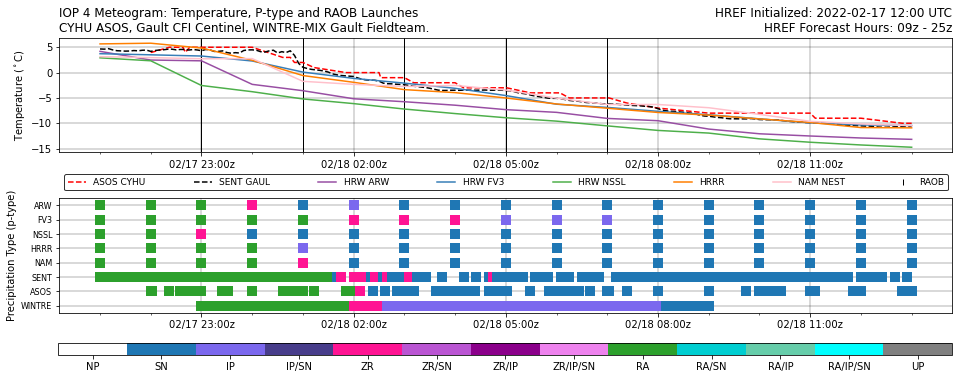

In [8]:
# Altering X-Axis intervals and formatting
def features(ax):
    ax.grid(color='black',linewidth=0.3)
    ax.xaxis.set_major_formatter(dateFmt)
    ax.xaxis.set_major_locator(HourLocator(interval=3))
    ax.xaxis.set_minor_locator(HourLocator(interval=1))
    
dateFmt = DateFormatter('%m/%d %H:00z')
dateFmt2 = DateFormatter('%Hz')

# Colormap
ptype_colors = [(1,1,1,1),'tab:blue','mediumslateblue','darkslateblue','deeppink','mediumorchid','darkmagenta','violet','tab:green','darkturquoise','mediumaquamarine','cyan','grey']
cmap_ptype_ext = mpl.colors.ListedColormap(ptype_colors)
norm_ptype_ext = mpl.colors.BoundaryNorm([-1,0,1,2,3,5,6,8,9,10,11,12,13,14],ncolors = len(ptype_colors))

# Title Formating
arw_name, fv3_name, nssl_name, ncep_name, nam_name = 'HRW ARW', 'HRW FV3', 'HRW NSSL', 'HRRR', 'NAM'
tl0,tl1,tl2,tl3 = f'IOP 4 Meteogram: Temperature, P-type and RAOB Launches' , f'{asos_station} ASOS, {sent_name} CFI Centinel, WINTRE-MIX {obs_name} Fieldteam.', f'HREF Initialized: {itime} UTC', f'HREF Forecast Hours: {str(fhrs_s).zfill(2)}z - {str(fhrs_e).zfill(2)}z'
title_line_left, title_line_right = (tl0+ '\n' + tl1), (tl2+ '\n' +tl3)
lc1,lc2,lc3,lc4,lc5 = '#984ea3','#377eb8','#4daf4a','#ff7f00','pink'
svt = f'{obs_name}_meteogram_{fhrs_s}'

# Temperature Figure
fig = plt.figure(figsize = (18, 25))
ax2 = fig.add_subplot (3, 1, 1)
plt.title(title_line_left,fontsize=12,loc = 'left')
plt.title(title_line_right,fontsize=12,loc = 'right')
plt.subplots_adjust(hspace = .4)
A = ax2.plot(asos_time,((df2['tmpf'] - 32) * 5/9), linestyle = '--', c='r', label = 'ASOS '+asos_station)
B = ax2.plot(sent_time,xr['temp_2m'].sel(station = sent_station), linestyle = '--', c='k', label = 'SENT '+sent_station)
ax2.plot(href_time,arw_TP, c=lc1, label = 'HRW ARW')
ax2.plot(href_time,fv3_TP, c=lc2, label = 'HRW FV3')
ax2.plot(href_time,nssl_TP, c=lc3, label = 'HRW NSSL')
ax2.plot(href_time,ncep_TP, c=lc4, label = 'HRRR')
ax2.plot(href_time,nam_TP, c=lc5, label = 'NAM NEST')
ax2.plot([], [], color='r', marker='|', ls='', label='RAOB', markeredgecolor='k')
ax2.set_ylabel ('Temperature ($^\circ$C)', fontsize = 10)
ax2.legend(loc='upper center',frameon=True,fontsize=9,shadow = False,edgecolor = 'black',mode = "expand", ncol = 8,bbox_to_anchor=(0.0, -.05, 1,-.1))

#IOP4 (Gault)
plt.axvspan('2022-02-17 23:00','2022-02-17 23:00',color = 'k',alpha=1, zorder = 1)
plt.axvspan('2022-02-18 01:00','2022-02-18 01:00',color = 'k',alpha=1, zorder = 1)
plt.axvspan('2022-02-18 03:00','2022-02-18 03:00',color = 'k',alpha=1, zorder = 1)
plt.axvspan('2022-02-18 05:00','2022-02-18 05:00',color = 'k',alpha=1, zorder = 1)
plt.axvspan('2022-02-18 07:00','2022-02-18 07:00',color = 'k',alpha=1, zorder = 1)

#IOP5 (Gault, Trios)
#plt.axvspan('2022-02-22 22:00','2022-02-22 22:00',color = 'k',alpha=1, zorder = 1)
#plt.axvspan('2022-02-23 00:00','2022-02-23 00:00',color = 'k',alpha=1, zorder = 1)
#plt.axvspan('2022-02-23 02:00','2022-02-23 02:00',color = 'k',alpha=1, zorder = 1)
#plt.axvspan('2022-02-23 04:00','2022-02-23 04:00',color = 'k',alpha=1, zorder = 1)


features(ax2)

# P-type Figure
ax1 = fig.add_subplot (3, 1, 2)
fig.set_size_inches(16, 8, forward=True)
s,s2=100, 100
ax1.scatter(href_time,arw_flat, marker='s', cmap = cmap_ptype_ext, norm = norm_ptype_ext,s = s2,edgecolors='none',c = arw_ptype, zorder = 5)
ax1.scatter(href_time,fv3_flat, marker='s', cmap = cmap_ptype_ext, norm = norm_ptype_ext,s = s2,edgecolors='none',c = fv3_ptype, zorder = 5)
ax1.scatter(href_time,nssl_flat, marker='s', cmap = cmap_ptype_ext, norm = norm_ptype_ext,s = s2,edgecolors='none',c = nssl_ptype, zorder = 5)
ax1.scatter(href_time,ncep_flat, marker='s', cmap = cmap_ptype_ext, norm = norm_ptype_ext,s = s2,edgecolors='none',c = ncep_ptype, zorder = 5)
ax1.scatter(href_time,nam_flat, marker='s', cmap = cmap_ptype_ext, norm = norm_ptype_ext,s = s2,edgecolors='none',c = nam_ptype, zorder = 5)
ax1.scatter(sent_time,x_type, marker = 's', cmap = cmap_ptype_ext, norm = norm_ptype_ext, s = s, edgecolors='none', c = PTYPE_df['GAUL'], zorder = 5)
ax1.scatter(asos_time,y_type, marker='s', cmap = cmap_ptype_ext, norm = norm_ptype_ext,s = s,edgecolors='none',c = df2['ptype'], zorder = 5)
ax1.scatter(obs_time,z_type, marker='s', cmap = cmap_ptype_ext, norm = norm_ptype_ext,s = s,edgecolors='none',c = sobs_df['Primary p-type'], zorder = 5)
ax1.set_ylabel ('Precipitation Type (p-type)', fontsize = 10)
ax1.set_ylim(1.05,1.85)
ax1.set_yticklabels(['WINTRE','ASOS','SENT','NAM','HRRR','NSSL','FV3', 'ARW'], fontsize = 8, fontweight = 'normal')
ax1.set_yticks([1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8])
features(ax1)

# Colorbar Figure
cbar_ptype = mpl.cm.ScalarMappable(norm = norm_ptype_ext, cmap = cmap_ptype_ext)
cbar_ptype.set_array([])
cax_apcp = fig.add_axes([0.124, 0.33, .776, 0.020])
ptype_ticks = [-0.5,0.5,1.5,2.5,4,5.5,7,8.5,9.5,10.5,11.5,12.5,13.5,14.5]
ptype_labels = ['NP','SN','IP','IP/SN','ZR','ZR/SN','ZR/IP','ZR/IP/SN','RA','RA/SN','RA/IP','RA/IP/SN','UP']
cbar = plt.colorbar(cbar_ptype, cax = cax_apcp, orientation = 'horizontal', ticks = ptype_ticks)
cbar.ax.set_xticklabels(ptype_labels)
cbar.ax.tick_params(labelsize=10)

fig.savefig(svt)

***

England, John | LU20230204